In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , random_split
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
device

device(type='cuda', index=0)

In [4]:
image_size = 256
transform_image = transforms.Compose([
                                      transforms.Resize((image_size , image_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485 , 0.456 , 0.406] , std = [0.229 , 0.224 , 0.225])
])

In [5]:
data_path = '/content/drive/MyDrive/Garbage_Classification DataSet/Garbage classification.zip (Unzipped Files)/Garbage classification'

In [6]:
img_data = ImageFolder(data_path , transform_image)

In [7]:
img_data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [8]:
training_data , validation_data , testing_data = random_split(img_data , [1600 , 827 , 100])
training_data[0]

(tensor([[[1.4954, 1.4954, 1.4954,  ..., 1.1015, 1.1015, 1.1015],
          [1.4954, 1.4954, 1.4954,  ..., 1.1015, 1.1015, 1.1015],
          [1.4954, 1.4954, 1.4954,  ..., 1.1015, 1.1015, 1.1015],
          ...,
          [1.4098, 1.4098, 1.4098,  ..., 0.6221, 0.6049, 0.6049],
          [1.3927, 1.3927, 1.3927,  ..., 0.6221, 0.6049, 0.6049],
          [1.3927, 1.3927, 1.3927,  ..., 0.6221, 0.6049, 0.6049]],
 
         [[1.6933, 1.6933, 1.6933,  ..., 1.2906, 1.2906, 1.2906],
          [1.6933, 1.6933, 1.6933,  ..., 1.2906, 1.2906, 1.2906],
          [1.6933, 1.6933, 1.6933,  ..., 1.2906, 1.2906, 1.2906],
          ...,
          [1.6232, 1.6232, 1.6232,  ..., 0.8004, 0.7829, 0.7829],
          [1.6057, 1.6057, 1.6057,  ..., 0.8004, 0.7829, 0.7829],
          [1.6057, 1.6057, 1.6057,  ..., 0.8004, 0.7829, 0.7829]],
 
         [[2.1346, 2.1346, 2.1346,  ..., 1.7337, 1.7337, 1.7337],
          [2.1346, 2.1346, 2.1346,  ..., 1.7163, 1.7163, 1.7163],
          [2.1346, 2.1346, 2.1346,  ...,

In [9]:
train_loader = DataLoader(training_data , batch_size=40 , shuffle = True)
val_loader = DataLoader(validation_data, batch_size=40 , shuffle = True)

In [10]:
for img , labels in train_loader:
  print(img.shape)
  break

torch.Size([40, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


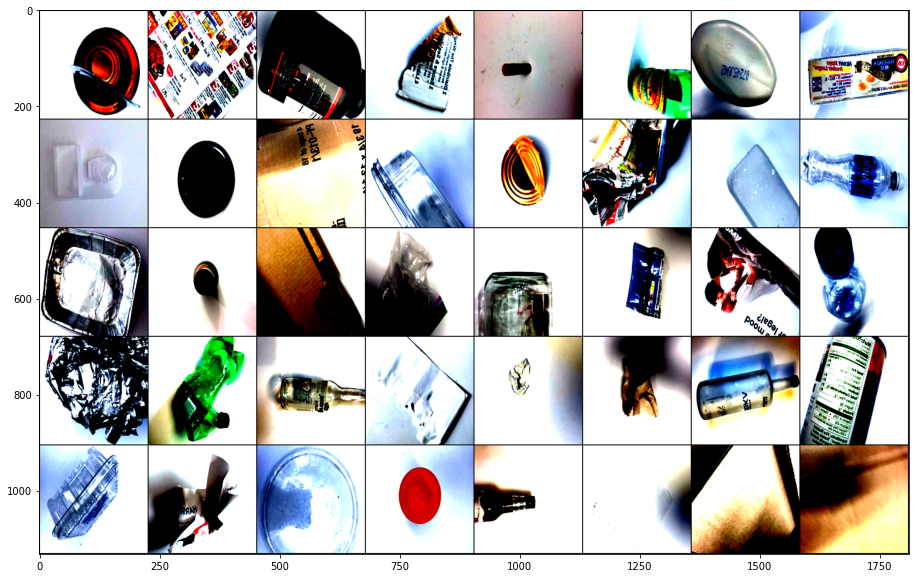

In [11]:
from torchvision.utils import make_grid
def imgShow(data):
  for img , label in data:
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(img , row_size = 10).permute(1,2,0))
    break
imgShow(train_loader)

In [17]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#  change the last layer 
resnet_model.fc = nn.Linear(in_features=512 , out_features=6)

In [14]:
# freeze the model parameters 
for params in resnet_model.parameters():
  params.requires_grad = False

In [21]:
def train_test_Model(loss_fn , optimizer , model , epoches = 20):
  training_acc = []
  training_loss = []
  testing_acc = []
  testing_loss = []

  for epoch in range(epoches):
    train_acc = 0.0
    train_loss = 0.0

    model.train()

    for images , labels in train_loader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output , labels)
      loss.backward()
      optimizer.step()
      prediction = torch.argmax(output , 1)
      train_acc += (prediction == labels).sum().item()
      train_loss += loss.item()
    training_acc.append(train_acc / len(training_data))
    training_loss.append(train_loss / len(train_loader))

    model.eval()

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():
      for images , labels in val_loader:

        images = images.to(device)
        labels = labels.to(device)
      
        output = model(images)
        loss = loss_fn(output , labels)
      
        prediction = torch.argmax(output , 1)
        test_acc += (prediction == labels).sum().item()
        test_loss += loss.item()
      testing_acc.append(test_acc / len(validation_data))
      testing_loss.append(test_loss / len(val_loader))
    print(f"Epochs:{epoch+1}, Training Accuracy:{train_acc/len(training_data):.2f}, Training Loss:{train_loss/len(train_loader):.2f}, Validation Accuracy:{test_acc/len(validation_data):2f}, Validation Loss:{test_loss/len(val_loader):.2f}")
  plt.title("Accuracy Vs Epochs")
  plt.plot(range(20), training_acc, label ="Training Accuracy")
  plt.plot(range(epoches), testing_acc, label = "Validation Accuracy")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()

  plt.title("Loss Vs Epochs")
  plt.plot(range(epoches), training_loss, label ="Training Loss")
  plt.plot(range(epoches), testing_loss, label = "Validation Loss")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()


Epochs:1, Training Accuracy:0.67, Training Loss:0.92, Validation Accuracy:0.644498, Validation Loss:0.98
Epochs:2, Training Accuracy:0.77, Training Loss:0.66, Validation Accuracy:0.516324, Validation Loss:1.76
Epochs:3, Training Accuracy:0.79, Training Loss:0.62, Validation Accuracy:0.732769, Validation Loss:0.86
Epochs:4, Training Accuracy:0.84, Training Loss:0.46, Validation Accuracy:0.736397, Validation Loss:0.91
Epochs:5, Training Accuracy:0.86, Training Loss:0.39, Validation Accuracy:0.750907, Validation Loss:0.76
Epochs:6, Training Accuracy:0.86, Training Loss:0.42, Validation Accuracy:0.652963, Validation Loss:1.38
Epochs:7, Training Accuracy:0.88, Training Loss:0.32, Validation Accuracy:0.626360, Validation Loss:1.53
Epochs:8, Training Accuracy:0.92, Training Loss:0.22, Validation Accuracy:0.773881, Validation Loss:0.70
Epochs:9, Training Accuracy:0.91, Training Loss:0.25, Validation Accuracy:0.754534, Validation Loss:0.83
Epochs:10, Training Accuracy:0.93, Training Loss:0.20, 

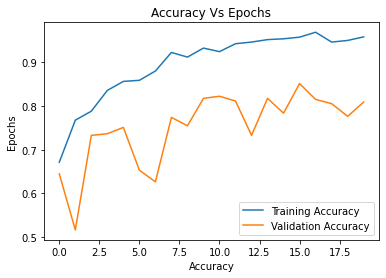

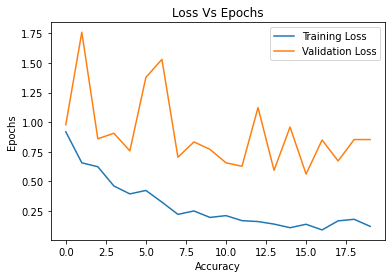

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters() , lr = 0.001)
train_test_Model(loss_func , optimizer , resnet_model)

In [28]:
def predict_func(img):
  img = img.to(device)
  x = img.unsqueeze(0)
  y = resnet_model(x)
  prediction = torch.argmax(y , 1)
  return img_data.classes[prediction]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label paper prediction label paper


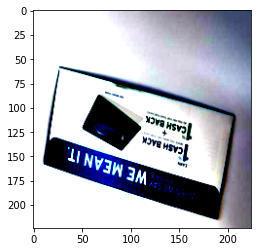

In [29]:
image , label = testing_data[5]    
plt.imshow(image.permute(1,2,0))
print("Actual Label", img_data.classes[label] , "prediction label" , predict_func(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label cardboard prediction label cardboard


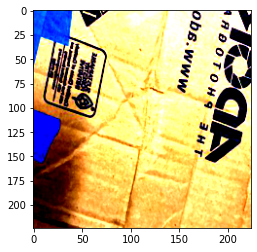

In [30]:
image , label = testing_data[50]    
plt.imshow(image.permute(1,2,0))
print("Actual Label", img_data.classes[label] , "prediction label" , predict_func(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label plastic prediction label plastic


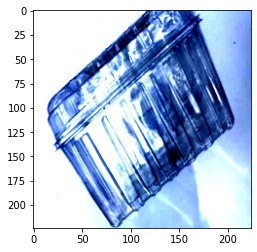

In [32]:
image , label = testing_data[80]    
plt.imshow(image.permute(1,2,0))
print("Actual Label", img_data.classes[label] , "prediction label" , predict_func(image))